After installing the package via `pip install qrmfold`, import it.

In [1]:
import qrmfold

# Initializing the Code


Initialize the quantum Reed–Muller code $\operatorname{QRM}(m)$ for $m =4$ and print its stabilizer generators and logical operators.
By default, the constructor minimizes the weight of each stabilizer generator to $2^{m/2 - 1}$
(according to Theorem 2)
but this can be controlled with the `minimize_weight` parameter.

In [2]:
bit_count = 4
code = qrmfold.QuantumReedMuller(bit_count, minimize_weight=True)
code.print()

X stabilizer generators:
+X_X_X_X_X_X_X_X_
+_X_X_X_X_X_X_X_X
+__XX__XX__XX__XX
+____XXXX____XXXX
+________XXXXXXXX
Z stabilizer generators:
+Z_Z_Z_Z_Z_Z_Z_Z_
+_Z_Z_Z_Z_Z_Z_Z_Z
+__ZZ__ZZ__ZZ__ZZ
+____ZZZZ____ZZZZ
+________ZZZZZZZZ
logical qubits and their X and Z operators:
0 {1, 2} +___X___X___X___X +____________ZZZZ
1 {1, 3} +_____X_X_____X_X +__________ZZ__ZZ
2 {1, 4} +_________X_X_X_X +______ZZ______ZZ
3 {2, 3} +______XX______XX +_________Z_Z_Z_Z
4 {2, 4} +__________XX__XX +_____Z_Z_____Z_Z
5 {3, 4} +____________XXXX +___Z___Z___Z___Z


The logical qubits are defined by subsets of $[m]$ of cardinality $m/2$.
During instantiation,
we can also specify:
1. the ordering of the logical qubits,
2. the starting logical index.

The default ordering, shown above, is lexicographic with starting index 0,
but the paper defines the canonical ordering (Definition 7) and indexes from 1.
This convention can be done as follows:

In [3]:
code_canonical = qrmfold.QuantumReedMuller(
    bit_count,
    logical_qubit_ordering=qrmfold.logical_qubit_orderings.canonical(bit_count, start_index=1),
)
code_canonical.print()

X stabilizer generators:
+X_X_X_X_X_X_X_X_
+_X_X_X_X_X_X_X_X
+__XX__XX__XX__XX
+____XXXX____XXXX
+________XXXXXXXX
Z stabilizer generators:
+Z_Z_Z_Z_Z_Z_Z_Z_
+_Z_Z_Z_Z_Z_Z_Z_Z
+__ZZ__ZZ__ZZ__ZZ
+____ZZZZ____ZZZZ
+________ZZZZZZZZ
logical qubits and their X and Z operators:
1 {1, 2} +___X___X___X___X +____________ZZZZ
4 {3, 4} +____________XXXX +___Z___Z___Z___Z
2 {1, 3} +_____X_X_____X_X +__________ZZ__ZZ
5 {2, 4} +__________XX__XX +_____Z_Z_____Z_Z
3 {1, 4} +_________X_X_X_X +______ZZ______ZZ
6 {2, 3} +______XX______XX +_________Z_Z_Z_Z


# Gates from Automorphisms

## Physical Circuits

We can get the physical circuits for $U_S(P(i, j)), U_P(P(i, j)), U_S(Q(i, j)), U_P(Q(i, j))$ using the `automorphism` method.
The output is in the form of a `stim.Circuit` object,
which can be visualized using its `diagram` method.
Here is an example for $U_P(P(1, 2))$:

In [4]:
pairs = [(1, 2)]
physical_circuit = code_canonical.automorphism(pairs, automorphism_type='P', gate_type='phase')
physical_circuit.diagram()

q0: -S-

 q1: -@-
      |
 q2: -@-

 q3: -S-

 q4: -S-

 q5: -@-
      |
 q6: -@-

 q7: -S-

 q8: -S-

 q9: -@-
      |
q10: -@-

q11: -S-

q12: -S-

q13: -@-
      |
q14: -@-

q15: -S-

Similarly, we can get the physical circuits for $U_S(P(K)), U_P(P(K)), U_S(Q(K)), U_P(Q(K))$ using the `automorphism_product` method.
Here is an example for $U_P(Q(1, 2)Q(3, 4))$:

In [6]:
pairs = [(1, 2), (3, 4)]
physical_circuit = code_canonical.automorphism_product(pairs, automorphism_type='Q', gate_type='phase')
physical_circuit.diagram()

q0: -S-S-------S-------S-

 q1: -S-S-------S-------S-

 q2: -S-@-------S-@-------
        |         |
 q3: -S-@-------S-@-------

 q4: -S-S-------S-------S-

 q5: -S-S-------S-------S-

 q6: -S-@-------S---@-----
        |           |
 q7: -S-@-------S---@-----

 q8: -S-S---@---------@---
            |         |
 q9: -S-S---|-@-----@-|---
            | |     | |
q10: -S-@---|-|-@-@-|-|---
        |   | | | | | |
q11: -S-@-@-|-|-|-|-|-|-@-
          | | | | | | | |
q12: -S-S-|-@-|-|-|-|-@-|-
          |   | | | |   |
q13: -S-S-|---@-|-|-@---|-
          |     | |     |
q14: -S-@-|-----@-|-----@-
        | |       |
q15: -S-@-@-------@-------

In the above circuit, there are many redundant gates because e.g. $S^4 =I$.
A basic depth-reduction technique is account for these repeated S and CZ gates;
this is done by `qrmfold.reduce_circuit_depth`:

In [9]:
qrmfold.reduce_circuit_depth(physical_circuit).diagram()

q0: -------------

 q1: -------------

 q2: -Z-----------

 q3: -Z-----------

 q4: -------------

 q5: -------------

 q6: -Z-----------

 q7: -Z-----------

 q8: -Z-----------

 q9: -Z-----------

q10: -S-@---@-@---
        |   | |
q11: -S-@-@-|-|-@-
          | | | |
q12: -Z---|-|-|-|-
          | | | |
q13: -Z---|-|-|-|-
          | | | |
q14: -S-@-|-@-|-@-
        | |   |
q15: -S-@-@---@---

## Intended Logical Action

The logical action of $U_P(Q(K))$ can be predicted using the following method (which uses Theorem 5):

In [18]:
code_canonical.q_phase_logical_action(pairs)

stim.Circuit('''
    I 1 4 2 5 3 6
    CZ 1 4 2 5 3 6 2 3
    Z 2 3
    CZ 2 6
    Z 2 6
    S 2
''')

...and that of $\prod_{L \subseteq K} U_P(Q(L))$ can be computed using the following method (which uses Theorem 6):

In [13]:
code_canonical.q_phase_product_logical_action(pairs)

stim.Circuit('''
    I 1 4 2 5 3 6
    S 2
''')

# Addressable Gates

An $\overline{S}$, $\overline{H}$, $\overline{\mathrm{C_{00}Z}}$, or $\overline{\mathrm{SW}}$ gate
on any (pair of) logical qubit(s) can be obtained using the `gate` method.
By default, this method applies the basic depth reduction from `qrmfold.reduce_circuit_depth`.
The `name` and `target` parameters behave similarly to `stim.Circuit.append`.
E.g. a logical Hadamard each on qubits 1 and 3 looks like:

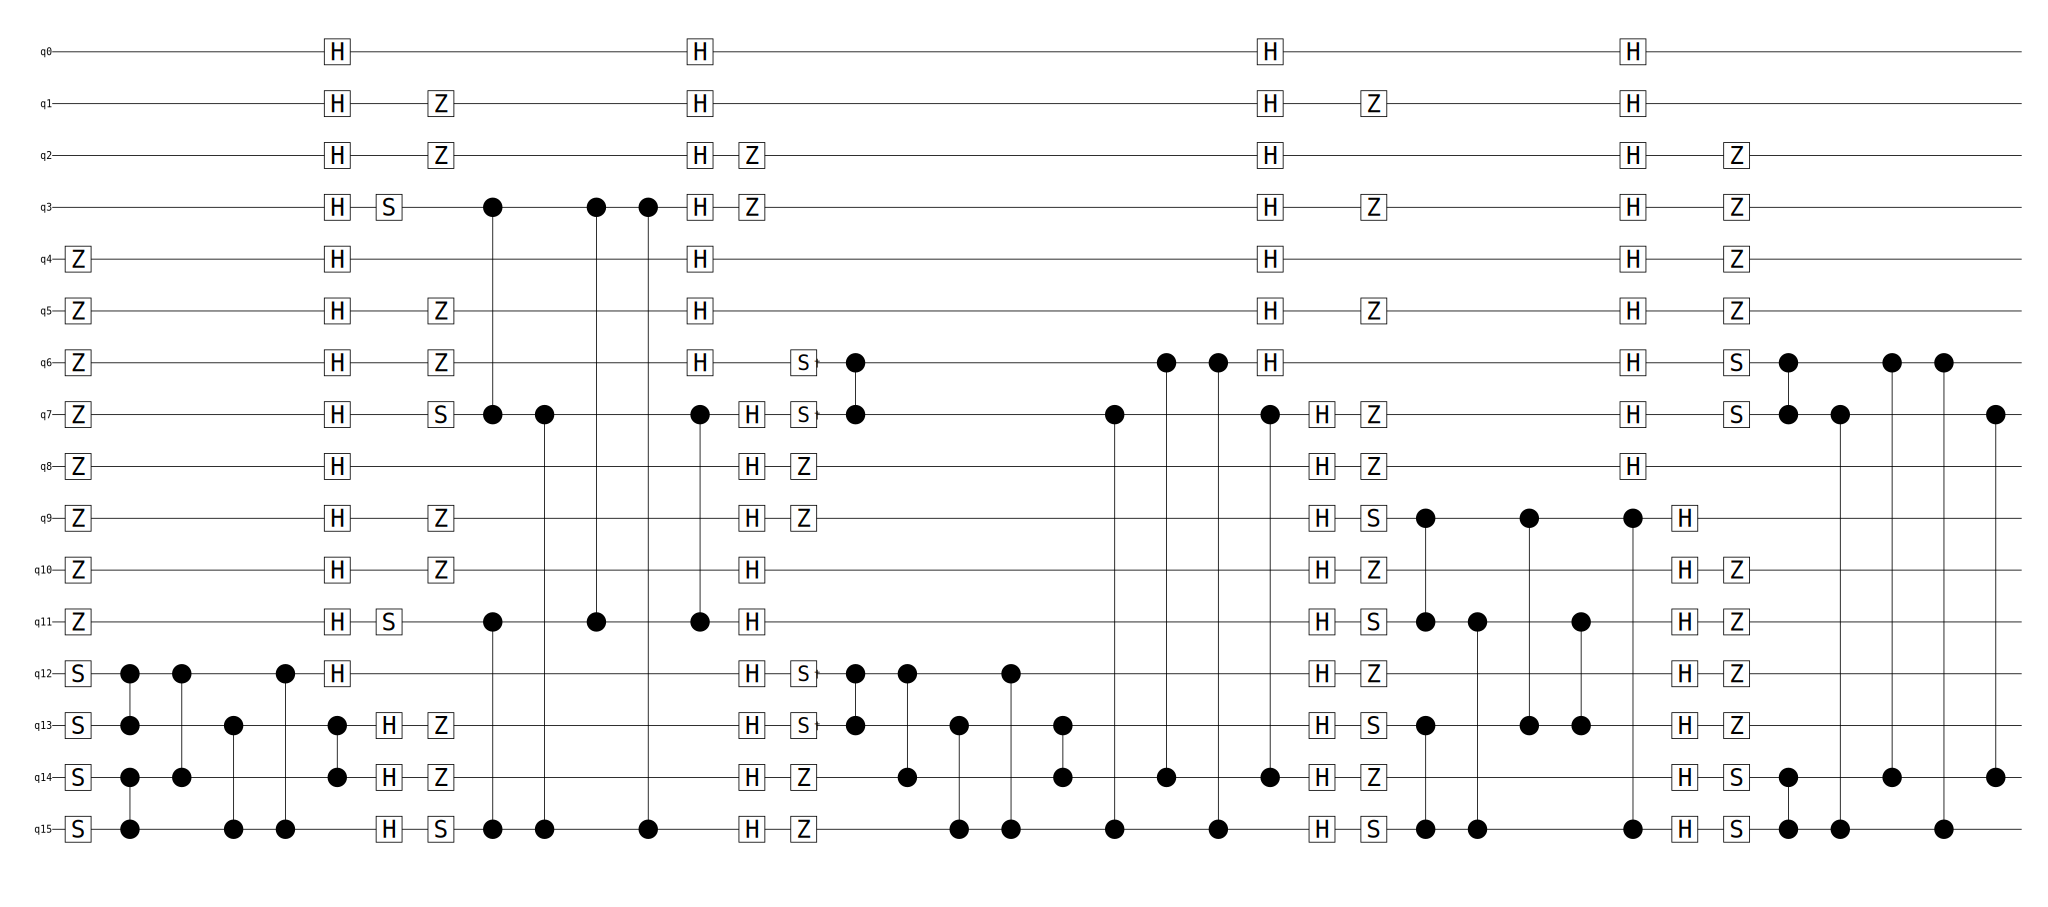

In [28]:
code_canonical.gate('H', [1, 3]).diagram('timeline')

...and one $\overline{\mathrm{C_{00}Z}}$ gate on qubits 1 and 3 looks like:

In [26]:
code_canonical.gate('ZZCZ', [1, 3]).diagram()

q0: -Z---

 q1: -Z---

 q2: -Z---

 q3: -Z---

 q4: -S-@-
        |
 q5: -S-@-

 q6: -S-@-
        |
 q7: -S-@-

 q8: -Z---

 q9: -Z---

q10: -Z---

q11: -Z---

q12: -S-@-
        |
q13: -S-@-

q14: -S-@-
        |
q15: -S-@-

Note the circuit depth of a 2-qubit gate depends on how different the subsets defining the logical qubits are. For example, one $\overline{\mathrm{C_{00}Z}}$ gate on qubits 1 and _4_ looks like:

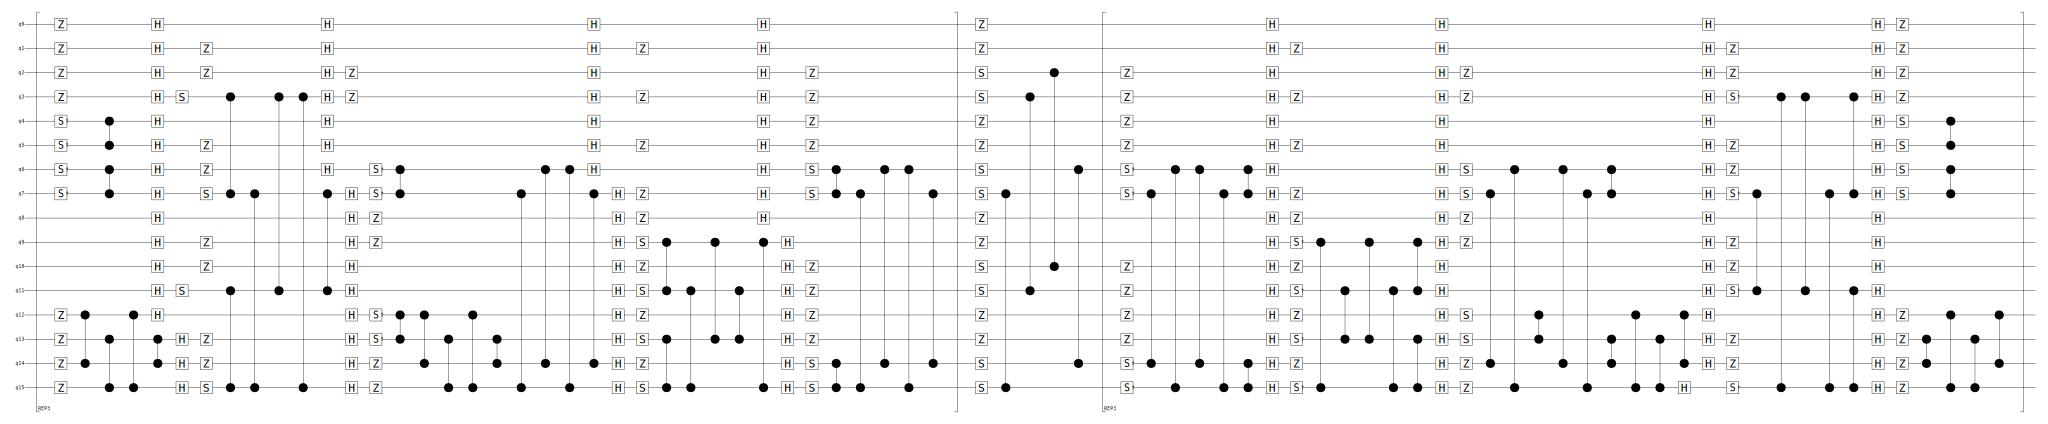

In [29]:
code_canonical.gate('ZZCZ', [1, 4]).diagram('timeline')

# Tests

This package uses the `pytest` framework.
Note there is one test, `test_quantum_reed_muller_integration.TestAddressableLogicalAction.test_2_qubit_gate`,
that takes considerably longer than the others.
The highest $m$ parameter it tests (i.e. 6) takes about 300 s on a laptop.